In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import joblib
from sklearn.compose import ColumnTransformer

def load_data(path):
    return pd.read_csv(path)

def preprocess_data(data):
    # Dropping unnecessary columns
    data.drop(["Patient Id","Patient First Name","Family Name","Father's name","Location of Institute",
               "Institute Name","Test 1","Test 2","Test 3","Test 4","Test 5","Symptom 1","Symptom 2",
               "Symptom 3","Symptom 4","Symptom 5"], inplace=True, axis=1)

    # Handling missing values
    data.replace(["No record", "Not available", "None", "Not applicable", "-"], np.nan, inplace=True)
    data.fillna(data.mode().iloc[0], inplace=True)

    # Renaming columns
    data.rename(columns={"Patient Age": "Patient_Age", "Genes in mother's side": "Genes_Mother_Side",
                         "Paternal gene": "Paternal_Gene", "Blood cell count (mcL)": "Blood_Cell_mcL",
                         "Mother's age": "Mother_Age", "Father's age": "Father_Age",
                         "Respiratory Rate (breaths/min)": "Respiratory_Rate_Breaths_Min",
                         "Heart Rate (rates/min": "Heart_Rates_Min", "Parental consent": "Parental_Consent",
                         "Follow-up": "Follow_Up", "Birth asphyxia": "Birth_Asphyxia",
                         "Autopsy shows birth defect (if applicable)": "Autopsy_Birth_Defect",
                         "Place of birth": "Place_Birth", "Folic acid details (peri-conceptional)": "Folic_Acid",
                         "H/O serious maternal illness": "Maternal_Illness",
                         "H/O radiation exposure (x-ray)": "Radiation_Exposure",
                         "H/O substance abuse": "Substance_Abuse",
                         "Assisted conception IVF/ART": "Assisted_Conception",
                         "History of anomalies in previous pregnancies": "History_Previous_Pregnancies",
                         "No. of previous abortion": "Previous_Abortion", "Birth defects": "Birth_Defects",
                         "White Blood cell count (thousand per microliter)": "White_Blood_Cell",
                         "Blood test result": "Blood_Test_Result", "Genetic Disorder": "Genetic_Disorder",
                         "Disorder Subclass": "Disorder_Subclass"}, inplace=True)
    data.rename(columns={"Inherited from father": "Inherited_Father", "Maternal gene": "Maternal_Gene"}, inplace=True)
    data.sort_values(by=["Patient_Age"], inplace=True)
    return data


# save preprocess data
data = load_data("data/Train.csv")
data = preprocess_data(data)
print(data.shape)
data.to_csv("data/train_preprocessed.csv", index=False)



c:\Users\ZAID\miniconda3\envs\ai_env_1\lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


(22083, 29)


GaussianNB:
	Accuracy: 0.7081729680778809
	Cross-Validation Score: 0.7059049260729934
RandomForestClassifier:
	Accuracy: 0.9080824088748018
	Cross-Validation Score: 0.894723017412093
GradientBoostingClassifier:
	Accuracy: 0.9155535431288204
	Cross-Validation Score: 0.9139691774145555
XGBClassifier:
	Accuracy: 0.9151007471134254
	Cross-Validation Score: 0.9105744862047382
LGBMClassifier:
	Accuracy: 0.9155535431288204
	Cross-Validation Score: 0.9126106852997611
CatBoostClassifier:
	Accuracy: 0.9151007471134254
	Cross-Validation Score: 0.9137429330706641


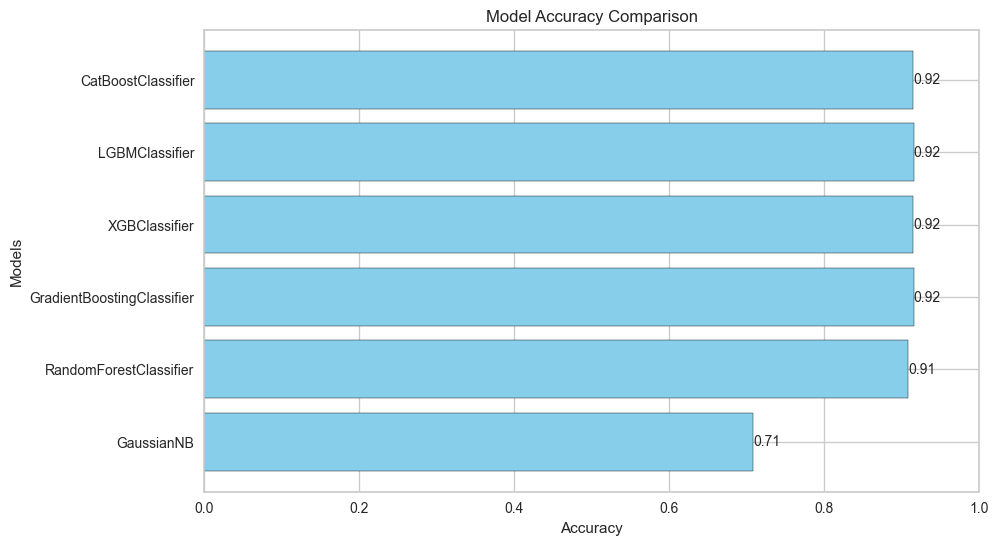

In [98]:


def train_evaluate_visualize_models(data, models):
    model_accuracies = []
    X = data.drop('Genetic_Disorder', axis=1)
    y = data['Genetic_Disorder']
    num_cols = X.select_dtypes(include=['int64', 'float64']).columns
    cat_cols = X.select_dtypes(include=['object']).columns
    # encode y
    y_enc = LabelEncoder()
    y = y_enc.fit_transform(y)

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_cols),
            ('cat', OrdinalEncoder(), cat_cols)
        ])
                                                                                        
    for model in models:
        pipeline_steps = [
            ('preprocessor', preprocessor),
            ('model', model)
        ]
        pipeline = Pipeline(steps=pipeline_steps)
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
        
            accuracy = accuracy_score(y_test, y_pred)
            cv_score = cross_val_score(pipeline, X_test, y_test, cv=10).mean()
            
            model_accuracies.append(accuracy)
            print(f"{model.__class__.__name__}:")
            print(f"\tAccuracy: {accuracy}")
            print(f"\tCross-Validation Score: {cv_score}")
            # save model
            joblib.dump(pipeline, f"models/{model.__class__.__name__}.joblib")
        except Exception as e:
            print(f"Error: {e}")
            accuracy, cv_score = 0, 0
            model_accuracies.append(accuracy)

    plt.figure(figsize=(10, 6))
    plt.barh([model.__class__.__name__ for model in models], model_accuracies, color='skyblue', edgecolor='black')
    # add text
    for i, model in enumerate(models):
        plt.text(model_accuracies[i], i, f'{model_accuracies[i]:.2f}', ha = 'left', va = 'center', fontsize=10)
    plt.xlabel('Accuracy')
    plt.ylabel('Models')
    plt.title('Model Accuracy Comparison')
    plt.xlim(0, 1)
    plt.show()
    # save encoded y
    joblib.dump(y_enc, "models/y_encoder.joblib")

# Load data
data = load_data("data/train_preprocessed.csv")
# Define models
models = [
    GaussianNB(),
    # RandomForestClassifier(random_state=42, verbose=False), # too slow
    GradientBoostingClassifier(verbose=False),
    XGBClassifier(),
    LGBMClassifier(verbose=-1,),
    CatBoostClassifier(verbose=False)
]

# Train, evaluate, and visualize models
train_evaluate_visualize_models(data, models)

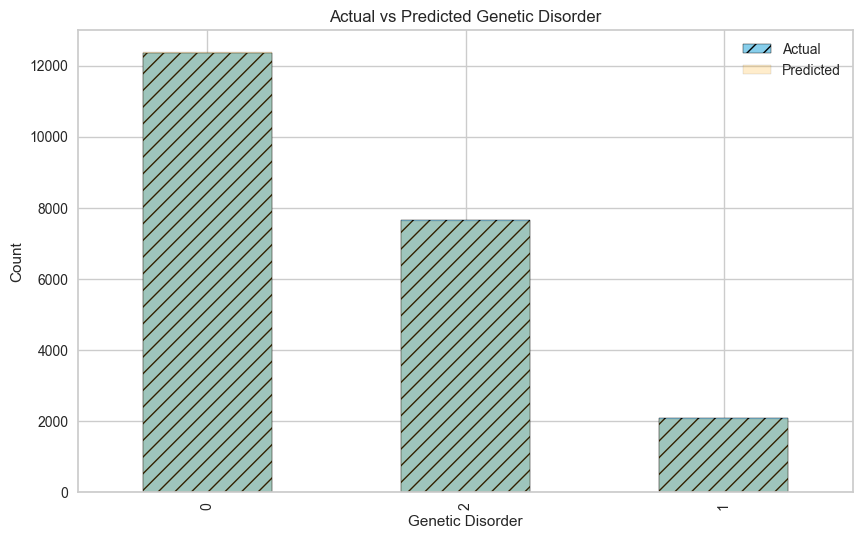

In [99]:
# prediction
data = load_data("data/train.csv")
data = preprocess_data(data)
prediction = predict(data)
data['y_pred'] = prediction
# compare prediction with actual using visualization
plt.figure(figsize=(10, 6))
data['Genetic_Disorder'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black', label='Actual', hatch='//')
data['y_pred'].value_counts().plot(kind='bar', color='orange', edgecolor='black', label='Predicted', alpha=0.2)
plt.legend()
plt.xlabel('Genetic Disorder')
plt.ylabel('Count')
plt.title('Actual vs Predicted Genetic Disorder')
plt.show()

In [6]:
data = load_data("data/train.csv")
data = preprocess_data(data)[:5]


def predict(dataframe):
    # load the best model GradientBoostingClassifier
    model = joblib.load("models/GradientBoostingClassifier.joblib")
    return model.predict(dataframe)

# single prediction
def predict_record(dataframe):
    predictions = predict(dataframe)
    print(f"Prediction: {predictions}")
    # decode prediction
    y_enc = joblib.load("models/y_encoder.joblib")
    predictions = y_enc.inverse_transform(predictions)
    return [
        {"idx": i, "prediction": pred} for i, pred in enumerate(predictions)
    ]
    
predict_record(
    data
)

Prediction: [2 0 1 2 2]


[{'idx': 0, 'prediction': 'Single-gene inheritance diseases'},
 {'idx': 1, 'prediction': 'Mitochondrial genetic inheritance disorders'},
 {'idx': 2, 'prediction': 'Multifactorial genetic inheritance disorders'},
 {'idx': 3, 'prediction': 'Single-gene inheritance diseases'},
 {'idx': 4, 'prediction': 'Single-gene inheritance diseases'}]